# Objectives

# Imports

In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, accuracy_score, precision_score


# Dataset

In [22]:
df = pd.read_csv('..\models\df_final.csv', low_memory=False)
display(df)

,Unnamed: 0.1,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,race,age,...,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs),urgency_score,urgency_x_lab_delay,admission_x_age
0,0,0,Full resistance,5.0,Strength L Arm,Neurological,13.116667,2724,OTHER,66,...,mg/dL,Unknown,1.900000,0,0.0,71.00,0.00,3,5.700000,198
1,1,1,1,1.0,20 Gauge Dressing Occlusive,Access Lines - Peripheral,4.183333,2724,HISPANIC/LATINO - CUBAN,80,...,%,ROUTINE,4.200000,0,23.6,60.00,121.00,6,25.200000,480
2,2,2,100,100.0,O2 saturation pulseoxymetry,Respiratory,5.316667,2724,WHITE,70,...,mg/dL,ROUTINE,20.000000,0,0.0,0.00,0.00,1,20.000000,70
3,3,3,Some resistance,4.0,Strength L Leg,Neurological,8.500000,2724,HISPANIC/LATINO - CUBAN,80,...,mEq/L,ROUTINE,4.200000,0,23.6,60.00,121.00,6,25.200000,480
4,4,4,106,106.0,Non Invasive Blood Pressure mean,Routine Vital Signs,1.583333,2724,WHITE,65,...,mEq/L,STAT,10.200000,0,0.0,0.00,0.00,6,61.200000,390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439545,439545,465283,74,74.0,Non Invasive Blood Pressure mean,Routine Vital Signs,14.450000,Z87891,WHITE,89,...,sec,ROUTINE,10.083333,0,26.0,66.00,161.16,6,60.500000,534
439546,439546,465284,-1 Awakens to voice (eye opening/contact) > 10...,-1.0,Richmond-RAS Scale,Pain/Sedation,16.516667,Z87891,WHITE,58,...,K/uL,STAT,2.566667,0,25.8,67.63,165.00,2,5.133333,116
439547,439547,465285,22,22.0,Peak Insp. Pressure,Respiratory,9.516667,Z87891,WHITE,58,...,sec,STAT,7.200000,0,25.8,67.63,165.00,2,14.400000,116
439548,439548,465286,74,74.0,Non Invasive Blood Pressure mean,Routine Vital Signs,4.766667,Z87891,WHITE,58,...,g/dL,STAT,5.483333,0,25.8,67.63,165.00,2,10.966667,116


In [36]:
df = df.drop(columns=['Unnamed: 0.1','Unnamed: 0'])

# Treatment

In [37]:
df = df.copy()

In [ ]:
class Treatment(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        df = X.copy()
        self.variables_cat = ['priority']
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.encoder.fit(df[self.variables_cat])
        self.ohe_columns = self.encoder.get_feature_names_out(self.variables_cat)

        self.label_encoders = {}
        variables_label = ['icd_code', 'category', 'race', 'lab_value_unit']
        
        for col in variables_label:
            if col in df.columns:
                le = LabelEncoder()
                le.fit(df[col].astype(str))
                self.label_encoders[col] = le

        return self

    def transform(self, X):
        df = X.copy()

        # Combined
        df['combined'] = np.where(
            (df['valueuom_chartevent'] == 'Unknown'),
            df['label_chartevent'],
            df['label_chartevent'] + ' (' + df['valueuom_chartevent'] + ')'
        )

        # Feature Interactions
        urgency_rank = {
            'ELECTIVE': 1, 'OBSERVATION ADMIT': 2,
            'SURGICAL SAME DAY ADMISSION': 3, 'URGENT': 4,
            'DIRECT EMER.': 5, 'EW EMER.': 6
        }
        df['urgency_score'] = df['admission_type'].map(urgency_rank)
        df['urgency_x_lab_delay'] = df['urgency_score'] * df['time_since_admission_labevent']
        df['admission_x_age'] = df['urgency_score'] * df['age']

        
        # OneHotEncoding
        one_hot_encoded = self.encoder.transform(df[self.variables_cat])
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=self.ohe_columns, index=df.index)
        df = pd.concat([df.drop(columns=self.variables_cat), one_hot_df], axis=1)

        # LabelEncoding 
        for col, le in self.label_encoders.items():
            if col in df.columns:
                df[col] = le.transform(df[col].astype(str))
            else:
                print(f"Aviso: Coluna '{col}' não encontrada em transform().")

        # Frequency
        df['value_chart'] = df['value_chart'].astype(str)
        df['value_chart_freq'] = df['value_chart'].map(df['value_chart'].value_counts())
        df.drop(columns=['value_chart'], inplace=True)

        df['chart_label'] = df['chart_label'].astype(str)
        df['chart_label_freq'] = df['chart_label'].map(df['chart_label'].value_counts())
        df.drop(columns=['chart_label'], inplace=True)

        return df

# Model

In [39]:

le = LabelEncoder()
y = le.fit_transform(df['icd_code'])
X = df.drop('icd_code', axis=1)

In [40]:
print(le.classes_)
joblib.dump(le, 'label_encoder_icd.pkl')

['2724' '4019' 'E039' 'E785' 'Z794' 'Z87891']


['label_encoder_icd.pkl']

In [41]:
treatment = Treatment()
X_processed = treatment.fit_transform(X)
joblib.dump(treatment, 'treatment.pkl')

['treatment.pkl']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.2, random_state=42)

In [43]:

param_dist = {
    'model__max_depth': [6],
    'model__learning_rate': [0.1],
    'model__gamma': [0.5],
    'model__min_child_weight': [3],
    'model__reg_alpha': [0],
    'model__reg_lambda': [1],
    'model__n_estimators': [200]  
}


pipeline = Pipeline([
    ('model', xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=len(le.classes_),
        tree_method='hist',
        eval_metric='mlogloss',
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        random_state=42
    ))
])

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_dist,
    scoring='precision_weighted',
    cv=5,
    n_jobs=-1,
    verbose=2 )

In [44]:

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [14:42:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None, num_class=6, ...))]),
             n_jobs=-1,
             param_grid={'model__gamma': [0.5], 'model__learning_rate': [0.1],
                         'model__max_depth': [6],
                         'model__min_child_weight': [3],
                         'model__n_estimators': [200], 'model__reg_alpha': [0],
                         'model__reg_lambda': [1]},
             scoring='precision_weighted', verbose=2)

In [45]:

y_pred = grid_search.predict(X_test)

# mean CV = 5
print("Accuracy - Internal validation:", grid_search.best_score_)

print("\nAccuracy - Real", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy - Internal validation: 0.7631992891649457

Accuracy - Real 0.7233648049141167
Precision (macro): 0.7473040260975431

Classification Report:
               precision    recall  f1-score   support

        2724       0.72      0.97      0.83     22454
        4019       0.95      0.61      0.74     21853
        E039       0.60      0.87      0.71     10601
        E785       0.87      0.11      0.20     11009
        Z794       0.79      1.00      0.88     10640
      Z87891       0.55      0.65      0.60     11353

    accuracy                           0.72     87910
   macro avg       0.75      0.70      0.66     87910
weighted avg       0.77      0.72      0.69     87910



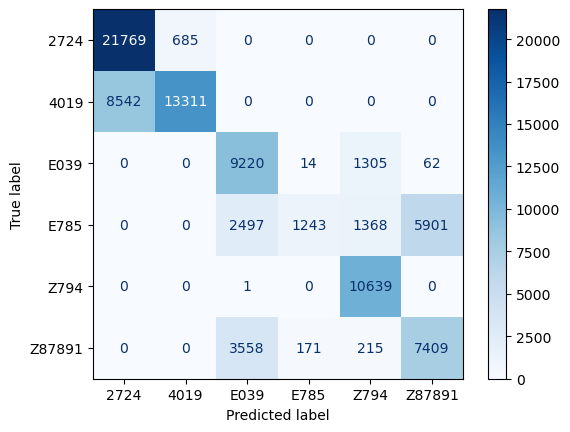

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cria a matriz de confusão
# Supondo que tens:
# y_test -> rótulos reais
# y_pred -> predições do modelo
# classes -> lista das classes (ex.: [0,1,2,3,4,5] ou códigos ICD)

cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão de forma visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues') 

In [46]:

joblib.dump(grid_search.best_estimator_, 'modelo_pipeline_final.pkl')

['modelo_pipeline_final.pkl']

# Example

## Download 

In [47]:
treatment = joblib.load('treatment.pkl')
pipeline = joblib.load('modelo_pipeline_final.pkl')
le = joblib.load('label_encoder_icd.pkl')

In [48]:
cases = pd.read_csv('..\models\cases.csv')

In [49]:
case = treatment.transform(cases)

expected_cols = pipeline.named_steps['model'].feature_names_in_
missing_cols = set(expected_cols) - set(case.columns)

print("Missing columns:")
print(missing_cols)


Aviso: Coluna 'lab_value_unit' não encontrada em transform().


KeyError: 'value_chart'

In [ ]:
display(cases)

,subject_id,value_chartevent,valuenum_chartevent,valueuom_chartevent,label_chartevent,category,time_since_admission_chartevent,admission_type,insurance,race,admission_location,age,value_labevent,valuenum_labevent,valueuom_labevent,priority,time_since_admission_labevent
0,1,No movement,36.8,Unknown,Temperature Celsius,Routine Vital Signs,12.00,URGENT,Medicare,WHITE,EMERGENCY ROOM,72,2.0,2.0,mg/dL,STAT,1.20
1,2,27,27.0,mA,Temporary Ventricular Stim Setting mA,Cardiovascular (Pacer Data),2.50,EW EMER.,Other,HISPANIC OR LATINO,PHYSICIAN REFERRAL,67,333.0,333.0,mm Hg,Unknown,2.00
2,3,8,8.0,insp/min,Resp Alarm - Low,Alarms,12.55,EW EMER.,Other,WHITE,PHYSICIAN REFERRAL,59,8.9,8.9,g/dL,STAT,14.95


In [20]:
preds = pipeline.predict(case)
print(preds)

[1 1 4]


In [21]:
lable = pd.read_csv('..\models\icd_match.csv')

In [22]:
icd_dict = dict(zip(lable['icd_code'], lable['long_title']))

In [24]:

predicted_icd_codes = le.inverse_transform(preds)
for i, (index, row) in enumerate(cases.iterrows()):
    icd_code = predicted_icd_codes[i]
    description = icd_dict.get(icd_code)
    
    print(f"Example {i+1}:")
    print(row.to_dict())  
    print(f"Result: {icd_code} - {description}")
    print("-" * 40)




Example 1:
{'subject_id': 1, 'value_chartevent': 'No movement', 'valuenum_chartevent': 36.8, 'valueuom_chartevent': 'Unknown', 'label_chartevent': 'Temperature Celsius', 'category': 'Routine Vital Signs', 'time_since_admission_chartevent': 12.0, 'admission_type': 'URGENT', 'insurance': 'Medicare', 'race': 'WHITE', 'admission_location': 'EMERGENCY ROOM', 'age': 72, 'value_labevent': 2.0, 'valuenum_labevent': 2.0, 'valueuom_labevent': 'mg/dL', 'priority': 'STAT', 'time_since_admission_labevent': 1.2}
Result: 4019 - Unspecified essential hypertension
----------------------------------------
Example 2:
{'subject_id': 2, 'value_chartevent': '27', 'valuenum_chartevent': 27.0, 'valueuom_chartevent': 'mA', 'label_chartevent': 'Temporary Ventricular Stim Setting mA', 'category': 'Cardiovascular (Pacer Data)', 'time_since_admission_chartevent': 2.5, 'admission_type': 'EW EMER.', 'insurance': 'Other', 'race': 'HISPANIC OR LATINO', 'admission_location': 'PHYSICIAN REFERRAL', 'age': 67, 'value_labe